In [1]:
import importlib
import xarray as xr
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors
import pandas as pd
from math import nan
import math
from glob import glob
import datetime as dt

from CASutils import mapplot_utils as maps
from CASutils import filter_utils as filt 

from cmocean import cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

importlib.reload(maps)
importlib.reload(filt)

<module 'CASutils.filter_utils' from '/home/dhruv/CASanalysis/CASutils/filter_utils.py'>

In [10]:
def jja_std_anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    jja_std = anoms.sel(time=anoms['time.season']=='JJA').std()
    std_anoms = anoms/jja_std
    return std_anoms

In [11]:
def remove_time_mean(x):
    return(x - x.mean(dim='time'))

def remove_annual_cycle(x):
#     return((x-x.groupby('time.month').mean()).drop('month'))
    return x.groupby('time.year').map(remove_time_mean)

In [12]:
t2m_files = ["/home/data/ERA5/day/T2m_day/t2m_{}.nc".format(i) for i in range(1979, 2020)]
t2m = xr.open_mfdataset(t2m_files)

lhflx_files = ["/home/data/ERA5/day/LHFLX_day/lhflx_{}.nc".format(i) for i in range(1979, 2020)]
lhflx = xr.open_mfdataset(lhflx_files)

shflx_files = ["/home/data/ERA5/day/SHFLX_day/shflx_{}.nc".format(i) for i in range(1979, 2020)]
shflx = xr.open_mfdataset(shflx_files)

In [13]:
extent = [-130, -65, 25, 65]

all_lats = t2m.lat.values
all_lons = t2m.lon.values

extent_lats, extent_lons = [], []

for lat in all_lats:
    if lat >= 25 and lat <= 65:
        print(lat)
        extent_lats.append(lat)
        
for lon in all_lons:
    if lon >= (-130+360) and lon <= (-65+360):
        print(lon)
        extent_lons.append(lon)

25.916230366492144
26.8586387434555
27.801047120418843
28.7434554973822
29.685863874345543
30.6282722513089
31.570680628272257
32.5130890052356
33.455497382198956
34.3979057591623
35.340314136125656
36.282722513089
37.225130890052355
38.16753926701571
39.10994764397907
40.0523560209424
40.994764397905755
41.93717277486911
42.87958115183247
43.8219895287958
44.764397905759154
45.70680628272251
46.64921465968587
47.591623036649224
48.53403141361255
49.47643979057591
50.41884816753927
51.36125654450262
52.30366492146598
53.24607329842931
54.188481675392666
55.13089005235602
56.07329842931938
57.01570680628271
57.958115183246065
58.90052356020942
59.84293193717278
60.785340314136135
61.727748691099464
62.67015706806282
63.61256544502618
64.55497382198953
230.0
231.25
232.5
233.75
235.0
236.25
237.5
238.75
240.0
241.25
242.5
243.75
245.0
246.25
247.5
248.75
250.0
251.25
252.5
253.75
255.0
256.25
257.5
258.75
260.0
261.25
262.5
263.75
265.0
266.25
267.5
268.75
270.0
271.25
272.5
273.75
275.0

In [14]:
lat=[]
lon=[]
std_anoms_shflx = []
std_anoms_lhflx = []
#std_anoms_sfmc = []
#std_anoms_t2m = []

for latitude in extent_lats:
    for longitude in extent_lons:
        print(latitude, longitude)
        
        s_t2m = t2m.t2m.sel(lat=latitude,lon=longitude).load()
        s_lhflx = lhflx.lhflx.sel(lat=latitude,lon=longitude).load()
        s_shflx = shflx.shflx.sel(lat=latitude,lon=longitude).load()
        
       # subset_anoms_sfmc = std_anoms(subset['SFMC'])
        subset_anoms_shflx = remove_annual_cycle(jja_std_anoms(s_shflx)) # the anomalies, standardized by JJA sd
        subset_anoms_lhflx = remove_annual_cycle(jja_std_anoms(s_lhflx))
       
      #  subset_anoms_t2m = std_anoms(subset['T2MMEAN'])
        t = remove_annual_cycle(jja_std_anoms(s_t2m))   # anomalies, not standardized, just JJA
        t = t.sel({'time':t['time.season']=='JJA'})
        heatwave_days = t[t>=t.quantile(0.9)].time.values
        pre_hw_1 = heatwave_days - np.timedelta64(1,'D')
        
        
        std_anoms_shflx.append(subset_anoms_shflx.sel(time=pre_hw_1).mean().item())
        std_anoms_lhflx.append(subset_anoms_lhflx.sel(time=pre_hw_1).mean().item())
       # std_anom_sfmc.append(subset_anoms_sfmc.sel(time=heatwave_days).mean().item())
       # std_anom_t2m.append(subset_anoms_t2m.sel(time=heatwave_days).mean().item())
        lat.append(latitude)
        lon.append(longitude)
        
df_3 = pd.DataFrame({'lat':lat,'lon':lon,'std_anoms_shflx':std_anoms_shflx,'std_anoms_lhflx':std_anoms_lhflx})

25.916230366492144 230.0
25.916230366492144 231.25
25.916230366492144 232.5
25.916230366492144 233.75
25.916230366492144 235.0
25.916230366492144 236.25
25.916230366492144 237.5
25.916230366492144 238.75
25.916230366492144 240.0
25.916230366492144 241.25
25.916230366492144 242.5
25.916230366492144 243.75
25.916230366492144 245.0
25.916230366492144 246.25
25.916230366492144 247.5
25.916230366492144 248.75
25.916230366492144 250.0
25.916230366492144 251.25
25.916230366492144 252.5
25.916230366492144 253.75
25.916230366492144 255.0
25.916230366492144 256.25
25.916230366492144 257.5
25.916230366492144 258.75
25.916230366492144 260.0
25.916230366492144 261.25
25.916230366492144 262.5
25.916230366492144 263.75
25.916230366492144 265.0
25.916230366492144 266.25
25.916230366492144 267.5
25.916230366492144 268.75
25.916230366492144 270.0
25.916230366492144 271.25
25.916230366492144 272.5
25.916230366492144 273.75
25.916230366492144 275.0
25.916230366492144 276.25
25.916230366492144 277.5
25.916

31.570680628272257 250.0
31.570680628272257 251.25
31.570680628272257 252.5
31.570680628272257 253.75
31.570680628272257 255.0
31.570680628272257 256.25
31.570680628272257 257.5
31.570680628272257 258.75
31.570680628272257 260.0
31.570680628272257 261.25
31.570680628272257 262.5
31.570680628272257 263.75
31.570680628272257 265.0
31.570680628272257 266.25
31.570680628272257 267.5
31.570680628272257 268.75
31.570680628272257 270.0
31.570680628272257 271.25
31.570680628272257 272.5
31.570680628272257 273.75
31.570680628272257 275.0
31.570680628272257 276.25
31.570680628272257 277.5
31.570680628272257 278.75
31.570680628272257 280.0
31.570680628272257 281.25
31.570680628272257 282.5
31.570680628272257 283.75
31.570680628272257 285.0
31.570680628272257 286.25
31.570680628272257 287.5
31.570680628272257 288.75
31.570680628272257 290.0
31.570680628272257 291.25
31.570680628272257 292.5
31.570680628272257 293.75
31.570680628272257 295.0
32.5130890052356 230.0
32.5130890052356 231.25
32.5130890

37.225130890052355 272.5
37.225130890052355 273.75
37.225130890052355 275.0
37.225130890052355 276.25
37.225130890052355 277.5
37.225130890052355 278.75
37.225130890052355 280.0
37.225130890052355 281.25
37.225130890052355 282.5
37.225130890052355 283.75
37.225130890052355 285.0
37.225130890052355 286.25
37.225130890052355 287.5
37.225130890052355 288.75
37.225130890052355 290.0
37.225130890052355 291.25
37.225130890052355 292.5
37.225130890052355 293.75
37.225130890052355 295.0
38.16753926701571 230.0
38.16753926701571 231.25
38.16753926701571 232.5
38.16753926701571 233.75
38.16753926701571 235.0
38.16753926701571 236.25
38.16753926701571 237.5
38.16753926701571 238.75
38.16753926701571 240.0
38.16753926701571 241.25
38.16753926701571 242.5
38.16753926701571 243.75
38.16753926701571 245.0
38.16753926701571 246.25
38.16753926701571 247.5
38.16753926701571 248.75
38.16753926701571 250.0
38.16753926701571 251.25
38.16753926701571 252.5
38.16753926701571 253.75
38.16753926701571 255.0
38

42.87958115183247 292.5
42.87958115183247 293.75
42.87958115183247 295.0
43.8219895287958 230.0
43.8219895287958 231.25
43.8219895287958 232.5
43.8219895287958 233.75
43.8219895287958 235.0
43.8219895287958 236.25
43.8219895287958 237.5
43.8219895287958 238.75
43.8219895287958 240.0
43.8219895287958 241.25
43.8219895287958 242.5
43.8219895287958 243.75
43.8219895287958 245.0
43.8219895287958 246.25
43.8219895287958 247.5
43.8219895287958 248.75
43.8219895287958 250.0
43.8219895287958 251.25
43.8219895287958 252.5
43.8219895287958 253.75
43.8219895287958 255.0
43.8219895287958 256.25
43.8219895287958 257.5
43.8219895287958 258.75
43.8219895287958 260.0
43.8219895287958 261.25
43.8219895287958 262.5
43.8219895287958 263.75
43.8219895287958 265.0
43.8219895287958 266.25
43.8219895287958 267.5
43.8219895287958 268.75
43.8219895287958 270.0
43.8219895287958 271.25
43.8219895287958 272.5
43.8219895287958 273.75
43.8219895287958 275.0
43.8219895287958 276.25
43.8219895287958 277.5
43.82198952

49.47643979057591 245.0
49.47643979057591 246.25
49.47643979057591 247.5
49.47643979057591 248.75
49.47643979057591 250.0
49.47643979057591 251.25
49.47643979057591 252.5
49.47643979057591 253.75
49.47643979057591 255.0
49.47643979057591 256.25
49.47643979057591 257.5
49.47643979057591 258.75
49.47643979057591 260.0
49.47643979057591 261.25
49.47643979057591 262.5
49.47643979057591 263.75
49.47643979057591 265.0
49.47643979057591 266.25
49.47643979057591 267.5
49.47643979057591 268.75
49.47643979057591 270.0
49.47643979057591 271.25
49.47643979057591 272.5
49.47643979057591 273.75
49.47643979057591 275.0
49.47643979057591 276.25
49.47643979057591 277.5
49.47643979057591 278.75
49.47643979057591 280.0
49.47643979057591 281.25
49.47643979057591 282.5
49.47643979057591 283.75
49.47643979057591 285.0
49.47643979057591 286.25
49.47643979057591 287.5
49.47643979057591 288.75
49.47643979057591 290.0
49.47643979057591 291.25
49.47643979057591 292.5
49.47643979057591 293.75
49.47643979057591 29

55.13089005235602 263.75
55.13089005235602 265.0
55.13089005235602 266.25
55.13089005235602 267.5
55.13089005235602 268.75
55.13089005235602 270.0
55.13089005235602 271.25
55.13089005235602 272.5
55.13089005235602 273.75
55.13089005235602 275.0
55.13089005235602 276.25
55.13089005235602 277.5
55.13089005235602 278.75
55.13089005235602 280.0
55.13089005235602 281.25
55.13089005235602 282.5
55.13089005235602 283.75
55.13089005235602 285.0
55.13089005235602 286.25
55.13089005235602 287.5
55.13089005235602 288.75
55.13089005235602 290.0
55.13089005235602 291.25
55.13089005235602 292.5
55.13089005235602 293.75
55.13089005235602 295.0
56.07329842931938 230.0
56.07329842931938 231.25
56.07329842931938 232.5
56.07329842931938 233.75
56.07329842931938 235.0
56.07329842931938 236.25
56.07329842931938 237.5
56.07329842931938 238.75
56.07329842931938 240.0
56.07329842931938 241.25
56.07329842931938 242.5
56.07329842931938 243.75
56.07329842931938 245.0
56.07329842931938 246.25
56.07329842931938 24

60.785340314136135 280.0
60.785340314136135 281.25
60.785340314136135 282.5
60.785340314136135 283.75
60.785340314136135 285.0
60.785340314136135 286.25
60.785340314136135 287.5
60.785340314136135 288.75
60.785340314136135 290.0
60.785340314136135 291.25
60.785340314136135 292.5
60.785340314136135 293.75
60.785340314136135 295.0
61.727748691099464 230.0
61.727748691099464 231.25
61.727748691099464 232.5
61.727748691099464 233.75
61.727748691099464 235.0
61.727748691099464 236.25
61.727748691099464 237.5
61.727748691099464 238.75
61.727748691099464 240.0
61.727748691099464 241.25
61.727748691099464 242.5
61.727748691099464 243.75
61.727748691099464 245.0
61.727748691099464 246.25
61.727748691099464 247.5
61.727748691099464 248.75
61.727748691099464 250.0
61.727748691099464 251.25
61.727748691099464 252.5
61.727748691099464 253.75
61.727748691099464 255.0
61.727748691099464 256.25
61.727748691099464 257.5
61.727748691099464 258.75
61.727748691099464 260.0
61.727748691099464 261.25
61.727

In [15]:
df_3 = df_3.set_index(['lat', 'lon']).to_xarray()
df_3.to_netcdf("/home/dhruv/data/heatwave_anoms_pre_1.nc")

In [17]:
flux_anoms = xr.open_dataset("/home/dhruv/data/heatwave_anoms_pre_1.nc")

all_lats = flux_anoms.lat.data
all_lons = flux_anoms.lon.data
lats = []
lons = []
corr = [] # 'a' =  ++ , 'b' = '+-' , 'c' ='-+' , d='--' (assum shflx first)
for lat in all_lats:
    for lon in all_lons:
        if(flux_anoms.std_anoms_shflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
            if(flux_anoms.std_anoms_lhflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
                corr.append(-1)
            else:
                corr.append(-.5)
        if(flux_anoms.std_anoms_shflx.sel({'lat':lat, 'lon':lon}).data.item()<0):
            if(flux_anoms.std_anoms_lhflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
                corr.append(.5)
            else:
                corr.append(1)
        lats.append(lat)
        lons.append(lon)

era_corr_df = pd.DataFrame({'lat':lats, 'lon':lons, 'corrs':corr})
corr_xr_1 = era_corr_df.set_index(['lat', 'lon']).to_xarray()

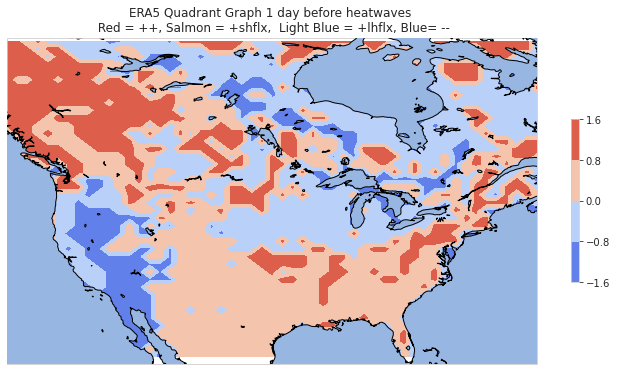

In [19]:
extent = [-130, -65, 25, 65]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

plt.contourf(corr_xr_1.lon, corr_xr_1.lat, corr_xr_1.corrs, cmap='coolwarm', levels=2)
plt.colorbar(shrink = 0.5)

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
ax.add_feature(cfeature.LAKES, edgecolor='black')

plt.title('ERA5 Quadrant Graph 1 day before heatwaves \n Red = ++, Salmon = +shflx,  Light Blue = +lhflx, Blue= --')
plt.show()

In [7]:
lat=[]
lon=[]
std_anoms_shflx = []
std_anoms_lhflx = []
#std_anoms_sfmc = []
#std_anoms_t2m = []

for latitude in extent_lats:
    for longitude in extent_lons:
        print(latitude, longitude)
        
        s_t2m = t2m.t2m.sel(lat=latitude,lon=longitude).load()
        s_lhflx = lhflx.lhflx.sel(lat=latitude,lon=longitude).load()
        s_shflx = shflx.shflx.sel(lat=latitude,lon=longitude).load()
        
       # subset_anoms_sfmc = std_anoms(subset['SFMC'])
        subset_anoms_shflx = remove_annual_cycle(jja_std_anoms(s_shflx)) # the anomalies, standardized by JJA sd
        subset_anoms_lhflx = remove_annual_cycle(jja_std_anoms(s_lhflx))
       
      #  subset_anoms_t2m = std_anoms(subset['T2MMEAN'])
        t = remove_annual_cycle(jja_std_anoms(s_t2m))   # anomalies, not standardized, just JJA
        t = t.sel({'time':t['time.season']=='JJA'})
        heatwave_days = t[t>=t.quantile(0.9)].time.values
        pre_hw_3 = heatwave_days - np.timedelta64(3,'D')
        
        
        std_anoms_shflx.append(subset_anoms_shflx.sel(time=pre_hw_3).mean().item())
        std_anoms_lhflx.append(subset_anoms_lhflx.sel(time=pre_hw_3).mean().item())
       # std_anom_sfmc.append(subset_anoms_sfmc.sel(time=heatwave_days).mean().item())
       # std_anom_t2m.append(subset_anoms_t2m.sel(time=heatwave_days).mean().item())
        lat.append(latitude)
        lon.append(longitude)
        
df_2 = pd.DataFrame({'lat':lat,'lon':lon,'std_anoms_shflx':std_anoms_shflx,'std_anoms_lhflx':std_anoms_lhflx})

25.916230366492144 230.0
25.916230366492144 231.25
25.916230366492144 232.5
25.916230366492144 233.75
25.916230366492144 235.0
25.916230366492144 236.25
25.916230366492144 237.5
25.916230366492144 238.75
25.916230366492144 240.0
25.916230366492144 241.25
25.916230366492144 242.5
25.916230366492144 243.75
25.916230366492144 245.0
25.916230366492144 246.25
25.916230366492144 247.5
25.916230366492144 248.75
25.916230366492144 250.0
25.916230366492144 251.25
25.916230366492144 252.5
25.916230366492144 253.75
25.916230366492144 255.0
25.916230366492144 256.25
25.916230366492144 257.5
25.916230366492144 258.75
25.916230366492144 260.0
25.916230366492144 261.25
25.916230366492144 262.5
25.916230366492144 263.75
25.916230366492144 265.0
25.916230366492144 266.25
25.916230366492144 267.5
25.916230366492144 268.75
25.916230366492144 270.0
25.916230366492144 271.25
25.916230366492144 272.5
25.916230366492144 273.75
25.916230366492144 275.0
25.916230366492144 276.25
25.916230366492144 277.5
25.916

31.570680628272257 250.0
31.570680628272257 251.25
31.570680628272257 252.5
31.570680628272257 253.75
31.570680628272257 255.0
31.570680628272257 256.25
31.570680628272257 257.5
31.570680628272257 258.75
31.570680628272257 260.0
31.570680628272257 261.25
31.570680628272257 262.5
31.570680628272257 263.75
31.570680628272257 265.0
31.570680628272257 266.25
31.570680628272257 267.5
31.570680628272257 268.75
31.570680628272257 270.0
31.570680628272257 271.25
31.570680628272257 272.5
31.570680628272257 273.75
31.570680628272257 275.0
31.570680628272257 276.25
31.570680628272257 277.5
31.570680628272257 278.75
31.570680628272257 280.0
31.570680628272257 281.25
31.570680628272257 282.5
31.570680628272257 283.75
31.570680628272257 285.0
31.570680628272257 286.25
31.570680628272257 287.5
31.570680628272257 288.75
31.570680628272257 290.0
31.570680628272257 291.25
31.570680628272257 292.5
31.570680628272257 293.75
31.570680628272257 295.0
32.5130890052356 230.0
32.5130890052356 231.25
32.5130890

37.225130890052355 272.5
37.225130890052355 273.75
37.225130890052355 275.0
37.225130890052355 276.25
37.225130890052355 277.5
37.225130890052355 278.75
37.225130890052355 280.0
37.225130890052355 281.25
37.225130890052355 282.5
37.225130890052355 283.75
37.225130890052355 285.0
37.225130890052355 286.25
37.225130890052355 287.5
37.225130890052355 288.75
37.225130890052355 290.0
37.225130890052355 291.25
37.225130890052355 292.5
37.225130890052355 293.75
37.225130890052355 295.0
38.16753926701571 230.0
38.16753926701571 231.25
38.16753926701571 232.5
38.16753926701571 233.75
38.16753926701571 235.0
38.16753926701571 236.25
38.16753926701571 237.5
38.16753926701571 238.75
38.16753926701571 240.0
38.16753926701571 241.25
38.16753926701571 242.5
38.16753926701571 243.75
38.16753926701571 245.0
38.16753926701571 246.25
38.16753926701571 247.5
38.16753926701571 248.75
38.16753926701571 250.0
38.16753926701571 251.25
38.16753926701571 252.5
38.16753926701571 253.75
38.16753926701571 255.0
38

42.87958115183247 292.5
42.87958115183247 293.75
42.87958115183247 295.0
43.8219895287958 230.0
43.8219895287958 231.25
43.8219895287958 232.5
43.8219895287958 233.75
43.8219895287958 235.0
43.8219895287958 236.25
43.8219895287958 237.5
43.8219895287958 238.75
43.8219895287958 240.0
43.8219895287958 241.25
43.8219895287958 242.5
43.8219895287958 243.75
43.8219895287958 245.0
43.8219895287958 246.25
43.8219895287958 247.5
43.8219895287958 248.75
43.8219895287958 250.0
43.8219895287958 251.25
43.8219895287958 252.5
43.8219895287958 253.75
43.8219895287958 255.0
43.8219895287958 256.25
43.8219895287958 257.5
43.8219895287958 258.75
43.8219895287958 260.0
43.8219895287958 261.25
43.8219895287958 262.5
43.8219895287958 263.75
43.8219895287958 265.0
43.8219895287958 266.25
43.8219895287958 267.5
43.8219895287958 268.75
43.8219895287958 270.0
43.8219895287958 271.25
43.8219895287958 272.5
43.8219895287958 273.75
43.8219895287958 275.0
43.8219895287958 276.25
43.8219895287958 277.5
43.82198952

49.47643979057591 245.0
49.47643979057591 246.25
49.47643979057591 247.5
49.47643979057591 248.75
49.47643979057591 250.0
49.47643979057591 251.25
49.47643979057591 252.5
49.47643979057591 253.75
49.47643979057591 255.0
49.47643979057591 256.25
49.47643979057591 257.5
49.47643979057591 258.75
49.47643979057591 260.0
49.47643979057591 261.25
49.47643979057591 262.5
49.47643979057591 263.75
49.47643979057591 265.0
49.47643979057591 266.25
49.47643979057591 267.5
49.47643979057591 268.75
49.47643979057591 270.0
49.47643979057591 271.25
49.47643979057591 272.5
49.47643979057591 273.75
49.47643979057591 275.0
49.47643979057591 276.25
49.47643979057591 277.5
49.47643979057591 278.75
49.47643979057591 280.0
49.47643979057591 281.25
49.47643979057591 282.5
49.47643979057591 283.75
49.47643979057591 285.0
49.47643979057591 286.25
49.47643979057591 287.5
49.47643979057591 288.75
49.47643979057591 290.0
49.47643979057591 291.25
49.47643979057591 292.5
49.47643979057591 293.75
49.47643979057591 29

55.13089005235602 263.75
55.13089005235602 265.0
55.13089005235602 266.25
55.13089005235602 267.5
55.13089005235602 268.75
55.13089005235602 270.0
55.13089005235602 271.25
55.13089005235602 272.5
55.13089005235602 273.75
55.13089005235602 275.0
55.13089005235602 276.25
55.13089005235602 277.5
55.13089005235602 278.75
55.13089005235602 280.0
55.13089005235602 281.25
55.13089005235602 282.5
55.13089005235602 283.75
55.13089005235602 285.0
55.13089005235602 286.25
55.13089005235602 287.5
55.13089005235602 288.75
55.13089005235602 290.0
55.13089005235602 291.25
55.13089005235602 292.5
55.13089005235602 293.75
55.13089005235602 295.0
56.07329842931938 230.0
56.07329842931938 231.25
56.07329842931938 232.5
56.07329842931938 233.75
56.07329842931938 235.0
56.07329842931938 236.25
56.07329842931938 237.5
56.07329842931938 238.75
56.07329842931938 240.0
56.07329842931938 241.25
56.07329842931938 242.5
56.07329842931938 243.75
56.07329842931938 245.0
56.07329842931938 246.25
56.07329842931938 24

60.785340314136135 280.0
60.785340314136135 281.25
60.785340314136135 282.5
60.785340314136135 283.75
60.785340314136135 285.0
60.785340314136135 286.25
60.785340314136135 287.5
60.785340314136135 288.75
60.785340314136135 290.0
60.785340314136135 291.25
60.785340314136135 292.5
60.785340314136135 293.75
60.785340314136135 295.0
61.727748691099464 230.0
61.727748691099464 231.25
61.727748691099464 232.5
61.727748691099464 233.75
61.727748691099464 235.0
61.727748691099464 236.25
61.727748691099464 237.5
61.727748691099464 238.75
61.727748691099464 240.0
61.727748691099464 241.25
61.727748691099464 242.5
61.727748691099464 243.75
61.727748691099464 245.0
61.727748691099464 246.25
61.727748691099464 247.5
61.727748691099464 248.75
61.727748691099464 250.0
61.727748691099464 251.25
61.727748691099464 252.5
61.727748691099464 253.75
61.727748691099464 255.0
61.727748691099464 256.25
61.727748691099464 257.5
61.727748691099464 258.75
61.727748691099464 260.0
61.727748691099464 261.25
61.727

In [8]:
df_2 = df_2.set_index(['lat', 'lon']).to_xarray()
df_2.to_netcdf("/home/dhruv/data/heatwave_anoms_pre_3.nc")

In [9]:
lat=[]
lon=[]
std_anoms_shflx = []
std_anoms_lhflx = []
#std_anoms_sfmc = []
#std_anoms_t2m = []

for latitude in extent_lats:
    for longitude in extent_lons:
        print(latitude, longitude)
        
        s_t2m = t2m.t2m.sel(lat=latitude,lon=longitude).load()
        s_lhflx = lhflx.lhflx.sel(lat=latitude,lon=longitude).load()
        s_shflx = shflx.shflx.sel(lat=latitude,lon=longitude).load()
        
       # subset_anoms_sfmc = std_anoms(subset['SFMC'])
        subset_anoms_shflx = remove_annual_cycle(jja_std_anoms(s_shflx)) # the anomalies, standardized by JJA sd
        subset_anoms_lhflx = remove_annual_cycle(jja_std_anoms(s_lhflx))
       
      #  subset_anoms_t2m = std_anoms(subset['T2MMEAN'])
        t = remove_annual_cycle(jja_std_anoms(s_t2m))   # anomalies, not standardized, just JJA
        t = t.sel({'time':t['time.season']=='JJA'})
        heatwave_days = t[t>=t.quantile(0.9)].time.values
        pre_hw_5 = heatwave_days - np.timedelta64(5,'D')
        
        
        std_anoms_shflx.append(subset_anoms_shflx.sel(time=pre_hw_5).mean().item())
        std_anoms_lhflx.append(subset_anoms_lhflx.sel(time=pre_hw_5).mean().item())
       # std_anom_sfmc.append(subset_anoms_sfmc.sel(time=heatwave_days).mean().item())
       # std_anom_t2m.append(subset_anoms_t2m.sel(time=heatwave_days).mean().item())
        lat.append(latitude)
        lon.append(longitude)
        
df = pd.DataFrame({'lat':lat,'lon':lon,'std_anoms_shflx':std_anoms_shflx,'std_anoms_lhflx':std_anoms_lhflx})

25.916230366492144 230.0
25.916230366492144 231.25
25.916230366492144 232.5
25.916230366492144 233.75
25.916230366492144 235.0
25.916230366492144 236.25
25.916230366492144 237.5
25.916230366492144 238.75
25.916230366492144 240.0
25.916230366492144 241.25
25.916230366492144 242.5
25.916230366492144 243.75
25.916230366492144 245.0
25.916230366492144 246.25
25.916230366492144 247.5
25.916230366492144 248.75
25.916230366492144 250.0
25.916230366492144 251.25
25.916230366492144 252.5
25.916230366492144 253.75
25.916230366492144 255.0
25.916230366492144 256.25
25.916230366492144 257.5
25.916230366492144 258.75
25.916230366492144 260.0
25.916230366492144 261.25
25.916230366492144 262.5
25.916230366492144 263.75
25.916230366492144 265.0
25.916230366492144 266.25
25.916230366492144 267.5
25.916230366492144 268.75
25.916230366492144 270.0
25.916230366492144 271.25
25.916230366492144 272.5
25.916230366492144 273.75
25.916230366492144 275.0
25.916230366492144 276.25
25.916230366492144 277.5
25.916

31.570680628272257 250.0
31.570680628272257 251.25
31.570680628272257 252.5
31.570680628272257 253.75
31.570680628272257 255.0
31.570680628272257 256.25
31.570680628272257 257.5
31.570680628272257 258.75
31.570680628272257 260.0
31.570680628272257 261.25
31.570680628272257 262.5
31.570680628272257 263.75
31.570680628272257 265.0
31.570680628272257 266.25
31.570680628272257 267.5
31.570680628272257 268.75
31.570680628272257 270.0
31.570680628272257 271.25
31.570680628272257 272.5
31.570680628272257 273.75
31.570680628272257 275.0
31.570680628272257 276.25
31.570680628272257 277.5
31.570680628272257 278.75
31.570680628272257 280.0
31.570680628272257 281.25
31.570680628272257 282.5
31.570680628272257 283.75
31.570680628272257 285.0
31.570680628272257 286.25
31.570680628272257 287.5
31.570680628272257 288.75
31.570680628272257 290.0
31.570680628272257 291.25
31.570680628272257 292.5
31.570680628272257 293.75
31.570680628272257 295.0
32.5130890052356 230.0
32.5130890052356 231.25
32.5130890

37.225130890052355 272.5
37.225130890052355 273.75
37.225130890052355 275.0
37.225130890052355 276.25
37.225130890052355 277.5
37.225130890052355 278.75
37.225130890052355 280.0
37.225130890052355 281.25
37.225130890052355 282.5
37.225130890052355 283.75
37.225130890052355 285.0
37.225130890052355 286.25
37.225130890052355 287.5
37.225130890052355 288.75
37.225130890052355 290.0
37.225130890052355 291.25
37.225130890052355 292.5
37.225130890052355 293.75
37.225130890052355 295.0
38.16753926701571 230.0
38.16753926701571 231.25
38.16753926701571 232.5
38.16753926701571 233.75
38.16753926701571 235.0
38.16753926701571 236.25
38.16753926701571 237.5
38.16753926701571 238.75
38.16753926701571 240.0
38.16753926701571 241.25
38.16753926701571 242.5
38.16753926701571 243.75
38.16753926701571 245.0
38.16753926701571 246.25
38.16753926701571 247.5
38.16753926701571 248.75
38.16753926701571 250.0
38.16753926701571 251.25
38.16753926701571 252.5
38.16753926701571 253.75
38.16753926701571 255.0
38

42.87958115183247 292.5
42.87958115183247 293.75
42.87958115183247 295.0
43.8219895287958 230.0
43.8219895287958 231.25
43.8219895287958 232.5
43.8219895287958 233.75
43.8219895287958 235.0
43.8219895287958 236.25
43.8219895287958 237.5
43.8219895287958 238.75
43.8219895287958 240.0
43.8219895287958 241.25
43.8219895287958 242.5
43.8219895287958 243.75
43.8219895287958 245.0
43.8219895287958 246.25
43.8219895287958 247.5
43.8219895287958 248.75
43.8219895287958 250.0
43.8219895287958 251.25
43.8219895287958 252.5
43.8219895287958 253.75
43.8219895287958 255.0
43.8219895287958 256.25
43.8219895287958 257.5
43.8219895287958 258.75
43.8219895287958 260.0
43.8219895287958 261.25
43.8219895287958 262.5
43.8219895287958 263.75
43.8219895287958 265.0
43.8219895287958 266.25
43.8219895287958 267.5
43.8219895287958 268.75
43.8219895287958 270.0
43.8219895287958 271.25
43.8219895287958 272.5
43.8219895287958 273.75
43.8219895287958 275.0
43.8219895287958 276.25
43.8219895287958 277.5
43.82198952

49.47643979057591 245.0
49.47643979057591 246.25
49.47643979057591 247.5
49.47643979057591 248.75
49.47643979057591 250.0
49.47643979057591 251.25
49.47643979057591 252.5
49.47643979057591 253.75
49.47643979057591 255.0
49.47643979057591 256.25
49.47643979057591 257.5
49.47643979057591 258.75
49.47643979057591 260.0
49.47643979057591 261.25
49.47643979057591 262.5
49.47643979057591 263.75
49.47643979057591 265.0
49.47643979057591 266.25
49.47643979057591 267.5
49.47643979057591 268.75
49.47643979057591 270.0
49.47643979057591 271.25
49.47643979057591 272.5
49.47643979057591 273.75
49.47643979057591 275.0
49.47643979057591 276.25
49.47643979057591 277.5
49.47643979057591 278.75
49.47643979057591 280.0
49.47643979057591 281.25
49.47643979057591 282.5
49.47643979057591 283.75
49.47643979057591 285.0
49.47643979057591 286.25
49.47643979057591 287.5
49.47643979057591 288.75
49.47643979057591 290.0
49.47643979057591 291.25
49.47643979057591 292.5
49.47643979057591 293.75
49.47643979057591 29

55.13089005235602 263.75
55.13089005235602 265.0
55.13089005235602 266.25
55.13089005235602 267.5
55.13089005235602 268.75
55.13089005235602 270.0
55.13089005235602 271.25
55.13089005235602 272.5
55.13089005235602 273.75
55.13089005235602 275.0
55.13089005235602 276.25
55.13089005235602 277.5
55.13089005235602 278.75
55.13089005235602 280.0
55.13089005235602 281.25
55.13089005235602 282.5
55.13089005235602 283.75
55.13089005235602 285.0
55.13089005235602 286.25
55.13089005235602 287.5
55.13089005235602 288.75
55.13089005235602 290.0
55.13089005235602 291.25
55.13089005235602 292.5
55.13089005235602 293.75
55.13089005235602 295.0
56.07329842931938 230.0
56.07329842931938 231.25
56.07329842931938 232.5
56.07329842931938 233.75
56.07329842931938 235.0
56.07329842931938 236.25
56.07329842931938 237.5
56.07329842931938 238.75
56.07329842931938 240.0
56.07329842931938 241.25
56.07329842931938 242.5
56.07329842931938 243.75
56.07329842931938 245.0
56.07329842931938 246.25
56.07329842931938 24

60.785340314136135 280.0
60.785340314136135 281.25
60.785340314136135 282.5
60.785340314136135 283.75
60.785340314136135 285.0
60.785340314136135 286.25
60.785340314136135 287.5
60.785340314136135 288.75
60.785340314136135 290.0
60.785340314136135 291.25
60.785340314136135 292.5
60.785340314136135 293.75
60.785340314136135 295.0
61.727748691099464 230.0
61.727748691099464 231.25
61.727748691099464 232.5
61.727748691099464 233.75
61.727748691099464 235.0
61.727748691099464 236.25
61.727748691099464 237.5
61.727748691099464 238.75
61.727748691099464 240.0
61.727748691099464 241.25
61.727748691099464 242.5
61.727748691099464 243.75
61.727748691099464 245.0
61.727748691099464 246.25
61.727748691099464 247.5
61.727748691099464 248.75
61.727748691099464 250.0
61.727748691099464 251.25
61.727748691099464 252.5
61.727748691099464 253.75
61.727748691099464 255.0
61.727748691099464 256.25
61.727748691099464 257.5
61.727748691099464 258.75
61.727748691099464 260.0
61.727748691099464 261.25
61.727

In [10]:
df = df.set_index(['lat', 'lon']).to_xarray()
df.to_netcdf("/home/dhruv/data/heatwave_anoms_pre_5.nc")

In [20]:
flux_anoms = xr.open_dataset("/home/dhruv/data/heatwave_anoms_pre_5.nc")

all_lats = flux_anoms.lat.data
all_lons = flux_anoms.lon.data
lats = []
lons = []
corr = [] # 'a' =  ++ , 'b' = '+-' , 'c' ='-+' , d='--' (assum shflx first)
for lat in all_lats:
    for lon in all_lons:
        if(flux_anoms.std_anoms_shflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
            if(flux_anoms.std_anoms_lhflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
                corr.append(-1)
            else:
                corr.append(-.5)
        if(flux_anoms.std_anoms_shflx.sel({'lat':lat, 'lon':lon}).data.item()<0):
            if(flux_anoms.std_anoms_lhflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
                corr.append(.5)
            else:
                corr.append(1)
        lats.append(lat)
        lons.append(lon)

era_corr_df = pd.DataFrame({'lat':lats, 'lon':lons, 'corrs':corr})
corr_xr_5 = era_corr_df.set_index(['lat', 'lon']).to_xarray()

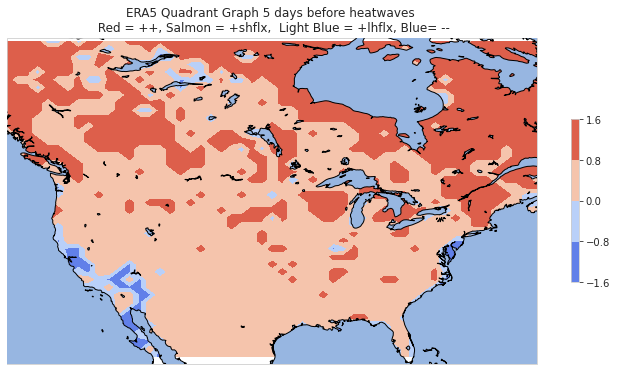

In [21]:
extent = [-130, -65, 25, 65]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

plt.contourf(corr_xr_5.lon, corr_xr_5.lat, corr_xr_5.corrs, cmap='coolwarm', levels=2)
plt.colorbar(shrink = 0.5)

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
ax.add_feature(cfeature.LAKES, edgecolor='black')

plt.title('ERA5 Quadrant Graph 5 days before heatwaves \n Red = ++, Salmon = +shflx,  Light Blue = +lhflx, Blue= --')
plt.show()

In [22]:
flux_anoms = xr.open_dataset("/home/dhruv/data/heatwave_anoms_pre_3.nc")

all_lats = flux_anoms.lat.data
all_lons = flux_anoms.lon.data
lats = []
lons = []
corr = [] # 'a' =  ++ , 'b' = '+-' , 'c' ='-+' , d='--' (assum shflx first)
for lat in all_lats:
    for lon in all_lons:
        if(flux_anoms.std_anoms_shflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
            if(flux_anoms.std_anoms_lhflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
                corr.append(-1)
            else:
                corr.append(-.5)
        if(flux_anoms.std_anoms_shflx.sel({'lat':lat, 'lon':lon}).data.item()<0):
            if(flux_anoms.std_anoms_lhflx.sel({'lat':lat, 'lon':lon}).data.item()>0):
                corr.append(.5)
            else:
                corr.append(1)
        lats.append(lat)
        lons.append(lon)

era_corr_df = pd.DataFrame({'lat':lats, 'lon':lons, 'corrs':corr})
corr_xr_3 = era_corr_df.set_index(['lat', 'lon']).to_xarray()

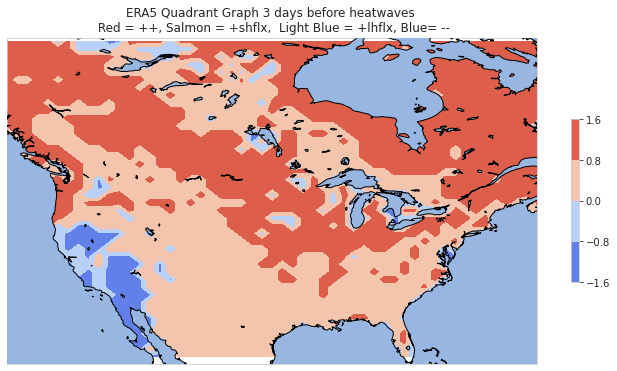

In [23]:
extent = [-130, -65, 25, 65]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

plt.contourf(corr_xr_3.lon, corr_xr_3.lat, corr_xr_3.corrs, cmap='coolwarm', levels=2)
plt.colorbar(shrink = 0.5)

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
ax.add_feature(cfeature.LAKES, edgecolor='black')

plt.title('ERA5 Quadrant Graph 3 days before heatwaves \n Red = ++, Salmon = +shflx,  Light Blue = +lhflx, Blue= --')
plt.show()